# Reddit Comments: Exploratory Analysis

## By Stephen Fox
## May 2017
_____

### Data Set Overview

* Reddit.com = 4th busiest website in the USA
* Over 1TB of Reddit comments (2007 - 2015) are available online
* Over 50GB of new comment data is generated each month
* Data could provide interesting insights into how people interact online 

### Personal Motivation

* Limited experience working with text based data sets = great learning experience
* Exploratory analysis on 1 month's worth of comments: September 2009 (1.2GB)

### Exploratory Data Analysis:

* Objective: get a better feel for the data set
    * what features does it contain?
    * is any cleaning required?
    * how are the features distributed?
    * are any features suitable for transformation?
    * are synthetic features needed?

#### 1. Download data and check basic information on the data set

In [1]:
# Import libaries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
from IPython.display import display
%matplotlib inline

# Load Reddit comment data and convert to Pandas dataframe
# Source: https://archive.org/download/2015_reddit_comments_corpus/reddit_data/
r_data = []
with open('RC_2009-09') as f:
    counter = 0
    for line in f:
        r_data.append(json.loads(line))
        counter += 1
        if counter % 500000 == 0:
            print "Processed %d comments\n" % (counter)

print "Data downloaded!"
            
r_data = pd.DataFrame(r_data)

# Pickle the dataframe for fast load time on future runs
r_data.to_pickle('RC_2009-09_pickle')

print "Data pickled!"

Processed 500000 comments

Processed 1000000 comments

Processed 1500000 comments

Processed 2000000 comments

Data downloaded!
Data pickled!


In [2]:
# Read pickled file into a data frame
r_data = pd.read_pickle('RC_2009-09_pickle')

print "Pickled data loaded to data frame!"

In [3]:
# Basic information on the data set
print "Number of unique comments in dataset:", len(r_data), "\n"
print "Number of data fields per commment:", len(r_data.dtypes.index), "\n"
print "Data field headers:"
print r_data.dtypes.index

Number of unique comments in dataset: 2032276 

Number of data fields per commment: 21 

Data field headers:
Index([u'archived', u'author', u'author_flair_css_class', u'author_flair_text',
       u'body', u'controversiality', u'created_utc', u'distinguished',
       u'downs', u'edited', u'gilded', u'id', u'link_id', u'name',
       u'parent_id', u'retrieved_on', u'score', u'score_hidden', u'subreddit',
       u'subreddit_id', u'ups'],
      dtype='object')


In [4]:
# Statistics on several fields of interest
print "'id' Field Overview:"
print r_data['id'].describe(),"\n"

print "'parent_id' Field Overview:"
print r_data['parent_id'].describe(),"\n"

print "'link_id' Field Overview:"
print r_data['link_id'].describe(),"\n"

print "'author' Field Overview:"
print r_data['author'].describe(),"\n"

print "'body' Field Overview:"
print r_data['body'].describe(),"\n"

print "'subreddit' Field Overview:"
print r_data['subreddit'].describe(),"\n"

print "'edited' Field Overview:"
print r_data['edited'].describe(),"\n"

print "'score' Field Overview:"
print r_data['score'].describe()

'id' Field Overview:
count     2032276
unique    2032276
top       c0dcvio
freq            1
Name: id, dtype: object 

'parent_id' Field Overview:
count      2032276
unique      985657
top       t3_9pgba
freq           796
Name: parent_id, dtype: object 

'link_id' Field Overview:
count      2032276
unique      157219
top       t3_9oj39
freq          7569
Name: link_id, dtype: object 

'author' Field Overview:
count       2032276
unique        77748
top       [deleted]
freq         599560
Name: author, dtype: object 

'body' Field Overview:
count       2032276
unique      1696352
top       [deleted]
freq         291868
Name: body, dtype: object 

'subreddit' Field Overview:
count       2032276
unique         1784
top       AskReddit
freq         365304
Name: subreddit, dtype: object 

'edited' Field Overview:
count     2032276
unique        804
top         False
freq      1798196
Name: edited, dtype: object 

'score' Field Overview:
count    2.032276e+06
mean     3.689649e+00
std      

##### Field Explanations:

* 'link_id': ID of the link the comment is in
* 'parent_id': ID of the thing the comment is a reply to, either the link or a commment in it (t3 = link; t1 = comment)

In [185]:
# Examine sample high and low scoring comments
pd.set_option('display.max_colwidth', -1)

#print "Lowest score comment:\n"
#print r_data['body'][r_data['score'] == min(r_data['score'])],"\n\n"
#print r_data['body'][(r_data['score'] > -300) & (r_data['score'] < -200)],"\n\n"

#print "Highest score comment:\n"
#print r_data['body'][r_data['score'] == max(r_data['score'])],"\n"
#print r_data['body'][(r_data['score'] > 1000) & (r_data['score'] < 1200)],"\n"

#print "Example low scoring comment:\n"
#print "Score:",r_data['score'][1296246]
#print r_data['body'][1296246]
#print "\n"
print "Example high scoring comment:\n"
print "Score:",r_data['score'][482885]
print r_data['body'][482885]

Example high scoring comment:

Score: 1096
An infinite number of mathematicians walk into a bar. The first one orders a beer. The second orders half a beer. The third, a quarter of a beer. The bartender says "You're all idiots", and pours two beers.


#### 2. Remove 'incomplete' data points (no body, no author)

In [6]:
# Drop data with deleted 'body' and 'author' values
data = r_data[r_data.body != '[deleted]']
data = r_data[r_data.author != '[deleted]']
data.reset_index(drop=True,inplace=True)
print "Number of comments left, after dropping those with deleted bodies and authors:",len(data)
print "Fraction of original data set kept:", "{0:.2f}".format(float(len(data))/len(r_data))

Number of comments left, after dropping those with deleted bodies and authors: 1432716
Fraction of original data set kept: 0.70


In [7]:
# Descriptive statistics on body comments
print data.body.describe()

count     1432716
unique    1398179
top       Yes.   
freq      576    
Name: body, dtype: object


In [12]:
# Descriptive statistics on authors
print data.author.describe()

count     1432574        
unique    77747          
top       NoMoreNicksLeft
freq      1981           
Name: author, dtype: object


#### 3. Consider the posting habits of prolific commenters vs. others

Some authors make hundreds of comments a month, others make just one. I would like to compare the prolific posters to the general population of authors, to see how they compare or contrast.

In [13]:
# Descriptive statistics on the top commenter's (NoMoreNicksLeft) score
print data['score'][data['author']=='NoMoreNicksLeft'].describe()

count    1981.000000
mean     1.645129   
std      8.104978   
min     -35.000000  
25%      0.000000   
50%      1.000000   
75%      2.000000   
max      199.000000 
Name: score, dtype: float64


In [14]:
# Count the number of authors with at least a certain number of threshold comments
author_data = data.groupby(data.author)

author_count = []
comment_count = []
comment_threshold_count = [0,1,5,10,20,50,100,200,300,400,500,600]

for count in comment_threshold_count:
    num_authors = author_data.filter(lambda x: len(x) > count).apply(pd.Series.nunique)['author']
    num_comments = author_data.filter(lambda x: len(x) > count).apply(pd.Series.nunique)['id']
    
    author_count.append(num_authors)
    comment_count.append(num_comments) 

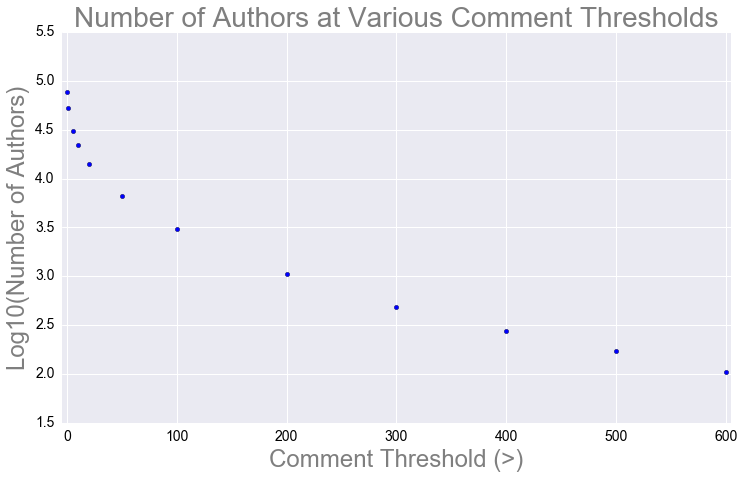

In [154]:
# Number of authors at various comment thresholds

# Seaborn plot traits
sns.despine()
fig, ax = plt.subplots()
plt.scatter(x=comment_threshold_count, y=np.log10(author_count))
ax.set_xlim([-5,605])
ax.set_title('Number of Authors at Various Comment Thresholds', fontsize=28,color="black",alpha=0.5)
ax.set_xlabel("Comment Threshold (>)",size = 24,color="black",alpha=0.5)
ax.set_ylabel("Log10(Number of Authors)",size = 24,color="black",alpha=0.5)
ax.tick_params(labelsize=14,labelcolor="black")
ax.legend()

fig.set_size_inches(12,7)

##### Key Observations:

Most authors make relatively few comments; a few authors comment prolifically:
* 1/10 authors made > 20 comments in a month
* 1/100 authors made > 200 comments in a month

In [17]:
# Calculate the Percent of Comments Contributed by Various Percent of Total Authors
total_authors = author_data.filter(lambda x: len(x) > 0).apply(pd.Series.nunique)['author']
total_comments = len(data)

percent_author = [100]
for count in author_count:
    percent = 100 * count / float(total_authors)
    percent_author.append(percent)

percent_comments = [100]
for count in comment_count:
    percent = 100 * count / float(total_comments)
    percent_comments.append(percent)

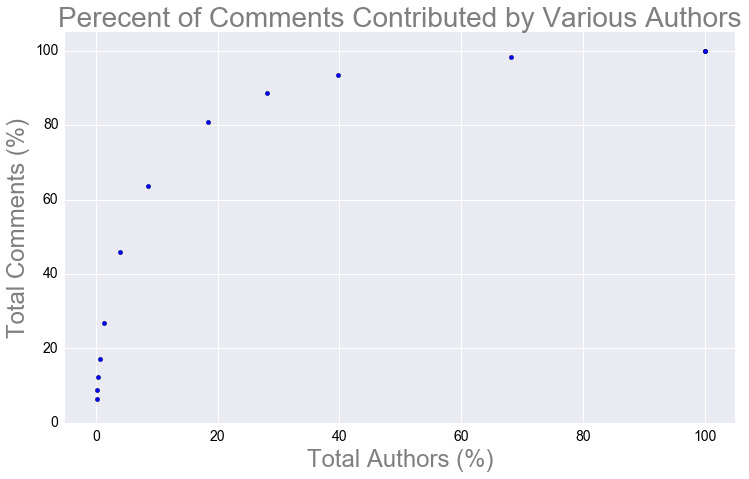

In [153]:
#plt.scatter(percent_author,percent_comments)

#fig, ax = plt.subplots()
#sns.pointplot(x=comment_threshold_count, y=np.log(author_count))
#ax.set_ylim([0,7000 ])

# Seaborn plot traits
sns.despine()
fig, ax = plt.subplots()
plt.scatter(percent_author,percent_comments)
ax.set_xlim([-5,105])
ax.set_ylim([0,105])
ax.set_title('Perecent of Comments Contributed by Various Authors', fontsize=28,color="black",alpha=0.5)
ax.set_xlabel("Total Authors (%)",size = 24,color="black",alpha=0.5)
ax.set_ylabel("Total Comments (%)",size = 24,color="black",alpha=0.5)
ax.tick_params(labelsize=14,labelcolor="black")
ax.legend()

fig.set_size_inches(12,7)

##### Key Observations:

Reddit comments are dominated by a small subset of authors:
* Greater than 80% of all comments are posted by 20% of the authors
* Greater than 90% of all comments are posted by 40% of the authors

This suggests it might be interesting to segment the data into different types of authors (prolific posters vs. not)

#### 4. Examine the length of the comment body field (i.e. actual comment text) for insights

In [19]:
# Add a synthetic feature: the length of each comment
data['body_length'] = data['body'].str.len()

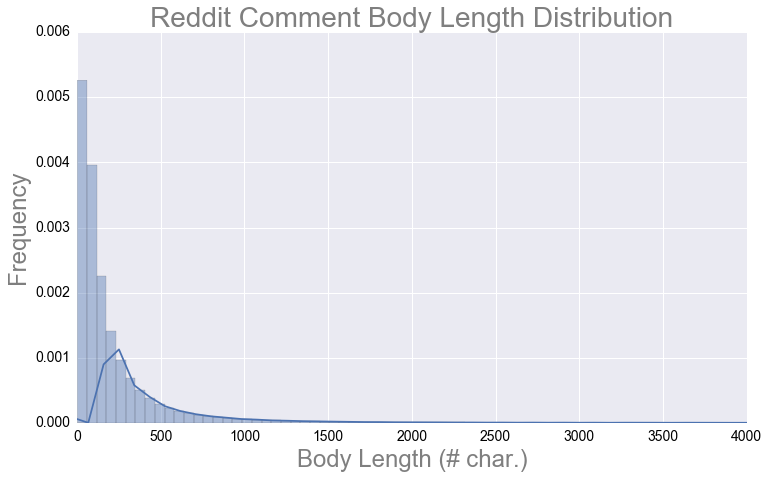

In [138]:
# Examine the distribution of comment body length (in characters)
x = data.body_length

# Seaborn plot traits
sns.despine()
fig, ax = plt.subplots()
sns.distplot(x, bins=200,ax=ax)
ax.set_xlim([0,4000])
ax.set_title('Reddit Comment Body Length Distribution', fontsize=28,color="black",alpha=0.5)
ax.set_xlabel("Body Length (# char.)",size = 24,color="black",alpha=0.5)
ax.set_ylabel("Frequency",size = 24,color="black",alpha=0.5)
ax.tick_params(labelsize=14,labelcolor="black")
ax.legend()

fig.set_size_inches(12,7)

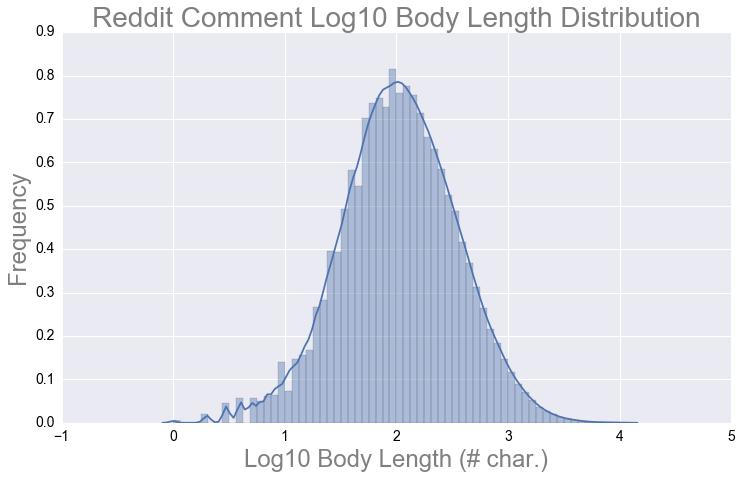

In [155]:
# Examine the distribution of Log comment body length (in characters)
x = np.log10(data.body_length)

# Seaborn plot traits
sns.despine()
fig, ax = plt.subplots()
sns.distplot(x, bins=65,ax=ax)
ax.set_title('Reddit Comment Log10 Body Length Distribution', fontsize=28,color="black",alpha=0.5)
ax.set_xlabel("Log10 Body Length (# char.)",size = 24,color="black",alpha=0.5)
ax.set_ylabel("Frequency",size = 24,color="black",alpha=0.5)
ax.tick_params(labelsize=14,labelcolor="black")
ax.legend()

fig.set_size_inches(12,7)

##### Key Observations:

* Most comments are in the 100 character range, with very few exceeding 1000 characters
* A log transformation on body length might be very useful for future analyses (e.g. machine learning), since normally distributed

#### 5. Compare body length and comment score between top commenters (>100 posts) and all commenters

In [22]:
# Define 'top authors' as those with at least 100 comment posts
top_authors = author_data.filter(lambda x: len(x) > 100)

In [23]:
# Compare top commenter statistics to all commenters
print "Top author's (>100 comments) statistics:\n"
display(top_authors.author.describe())
print "\nAll author's statistics:\n"
data.author.describe()

count     657971         
unique    3017           
top       NoMoreNicksLeft
freq      1981           
Name: author, dtype: object

count     1432574        
unique    77747          
top       NoMoreNicksLeft
freq      1981           
Name: author, dtype: object

##### Key Observation:

Only 3,017 out of 77,747 unique authors (3.9%) posted more than 100 comments in the month

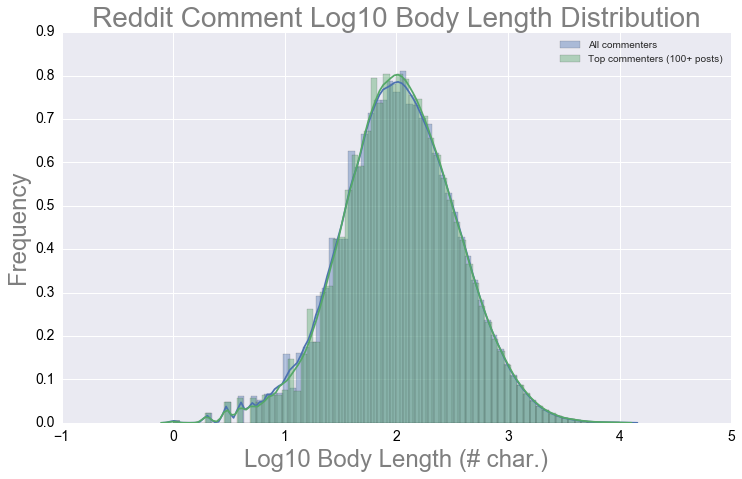

In [121]:
# Compare the comment body length between top user and all users via histogram

x = np.log10(data['body_length'])
y = np.log10(top_authors['body_length'])

# Seaborn plot traits
sns.despine()
fig, ax = plt.subplots()
sns.distplot(x, bins=70,ax=ax,label="All commenters")
sns.distplot(y, bins=70,ax=ax,label="Top commenters (100+ posts)")
ax.set_title('Reddit Comment Log10 Body Length Distribution', fontsize=28,color="black",alpha=0.5)
ax.set_xlabel("Log10 Body Length (# char.)",size = 24,color="black",alpha=0.5)
ax.set_ylabel("Frequency",size = 24,color="black",alpha=0.5)
ax.tick_params(labelsize=14,labelcolor="black")
ax.legend()

fig.set_size_inches(12,7)

In [65]:
# Statistics on comment body length, for all and top commenters:
print "Top author's (>100 comments) body length statistics:\n"
display(top_authors.body_length.describe())
print "\nAll author's body length statistics:\n"
display(data.body_length.describe())

Top author's (>100 comments) body length statistics:



count    657971.000000
mean     214.073061   
std      356.599137   
min      1.000000     
25%      50.000000    
50%      107.000000   
75%      236.000000   
max      9946.000000  
Name: body_length, dtype: float64


All author's body length statistics:



count    1.432574e+06
mean     2.115647e+02
std      3.491116e+02
min      1.000000e+00
25%      4.800000e+01
50%      1.050000e+02
75%      2.350000e+02
max      1.159100e+04
Name: body_length, dtype: float64

##### Key Observation:

Not much difference in body length distribution between prolific and all commenters: approx. equal mean and median values.

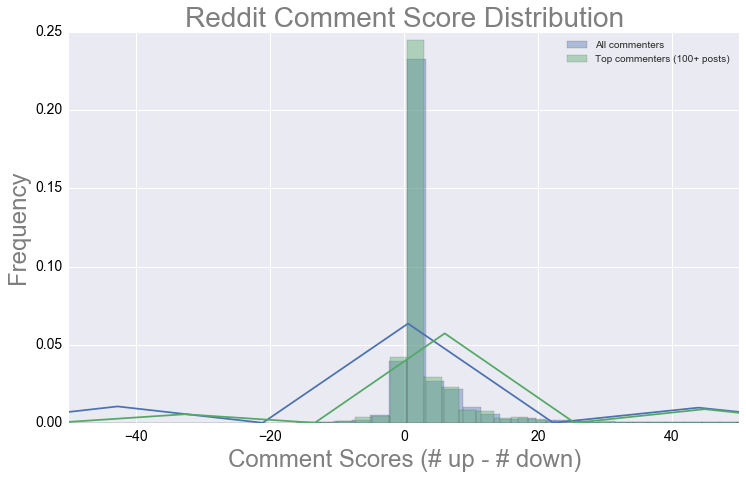

In [180]:
# Compare the score distribution between top user and all users via histogram
x = data['score']
y = top_authors['score']

# Seaborn plot traits
sns.despine()
fig, ax = plt.subplots()
sns.distplot(x, bins=1000,ax=ax,label="All commenters")
sns.distplot(y, bins=950,ax=ax,label="Top commenters (100+ posts)")
ax.set_xlim([-50, 50])
ax.set_title('Reddit Comment Score Distribution', fontsize=28,color="black",alpha=0.5)
ax.set_xlabel("Comment Scores (# up - # down)",size = 24,color="black",alpha=0.5)
ax.set_ylabel("Frequency",size = 24,color="black",alpha=0.5)
ax.tick_params(labelsize=14,labelcolor="black")
ax.legend()

fig.set_size_inches(12,7)

In [64]:
# Statistics on score, for all and top commenters:
print "Top author's (>100 comments) score statistics:\n"
display(top_authors.score.describe())
print "\nAll author's score statistics:\n"
display(data.score.describe())

Top author's (>100 comments) score statistics:



count    657971.000000
mean     4.018104     
std      16.119567    
min     -207.000000   
25%      1.000000     
50%      2.000000     
75%      3.000000     
max      2256.000000  
Name: score, dtype: float64


All author's score statistics:



count    1.432574e+06
mean     4.073547e+00
std      1.594196e+01
min     -4.980000e+02
25%      1.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      2.256000e+03
Name: score, dtype: float64

##### Key Observation:

* Majority of comments elicit no response (median score of 1 = default score on reddit.com)
* Top commenters earn slightly lower average scores
* Reddit community does not favor top commenters per se

### Sentiment Analysis

* Many reddit comments are emotionally charged or opinionated
* Sentiment analysis might be interesting on this set
* Proof-of-concept: use the VADER sentiment analysis tool 'off-the-shelf'
* VADER is a rule based sentiment analysis model for social media

For more information, refer to the following web site:
http://www.nltk.org/howto/sentiment.html

#### 1. Import and train the sentiment classifier

In [28]:
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
n_instances = 1000
subj_docs = [(sent, 'subj') for sent in subjectivity.sents(categories='subj')[:n_instances]]
obj_docs = [(sent, 'obj') for sent in subjectivity.sents(categories='obj')[:n_instances]]

In [29]:
# Each document is represented by a tuple (sentence, label). 
# The sentence is tokenized, so it is represented by a list of strings

# We separately split subjective and objective instances to keep 
#a balanced uniform class distribution in both train and test sets.

train_subj_docs = subj_docs[:800]
test_subj_docs = subj_docs[800:1000]
train_obj_docs = obj_docs[:800]
test_obj_docs = obj_docs[800:1000]
training_docs = train_subj_docs+train_obj_docs
testing_docs = test_subj_docs+test_obj_docs
sentim_analyzer = SentimentAnalyzer()
all_words_neg = sentim_analyzer.all_words([mark_negation(doc) for doc in training_docs])

In [30]:
# We use simple unigram word features, handling negation:

unigram_feats = sentim_analyzer.unigram_word_feats(all_words_neg, min_freq=4)
sentim_analyzer.add_feat_extractor(extract_unigram_feats, unigrams=unigram_feats)

In [31]:
# We apply features to obtain a feature-value representation of our datasets:

training_set = sentim_analyzer.apply_features(training_docs)
test_set = sentim_analyzer.apply_features(testing_docs)

In [32]:
# We can now train our classifier on the training set, 
#and subsequently output the evaluation results:

trainer = NaiveBayesClassifier.train
classifier = sentim_analyzer.train(trainer, training_set)

# Training classifier
for key,value in sorted(sentim_analyzer.evaluate(test_set).items()):
    print('{0}: {1}'.format(key, value))

Training classifier
Evaluating NaiveBayesClassifier results...
Accuracy: 0.835
F-measure [obj]: 0.826315789474
F-measure [subj]: 0.842857142857
Precision [obj]: 0.872222222222
Precision [subj]: 0.804545454545
Recall [obj]: 0.785
Recall [subj]: 0.885


#### 2. Observe model results on select sentences

In [33]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Sample sentences for evaluation
sentences = ["The book was good.",         # positive sentence
"The book was kind of good.", # qualified positive sentence is handled correctly (intensity adjusted)
"The plot was good, but the characters are uncompelling and the dialog is not great.", # mixed negation sentence
"A really bad, horrible book.",       # negative sentence with booster words
"At least it isn't a horrible book.", # negated negative sentence with contraction
":) and :D",     # emoticons handled
"",              # an empty string is correctly handled
"Today sux",
"I won't say that the movie is astounding and I wouldn't claim that \
the movie is too banal either."]

In [34]:
#from nltk import tokenize
#lines_list = tokenize.sent_tokenize(paragraph)
#sentences.extend(lines_list)
#tricky_sentences = [

sid = SentimentIntensityAnalyzer()
for sentence in sentences:
    print(sentence)
    ss = sid.polarity_scores(sentence)
    for k in sorted(ss):
        print('{0}: {1}, '.format(k, ss[k]))
    print()
    
print sid.polarity_scores('This is not hard!')

The book was good.
compound: 0.4404, 
neg: 0.0, 
neu: 0.508, 
pos: 0.492, 
()
The book was kind of good.
compound: 0.3832, 
neg: 0.0, 
neu: 0.657, 
pos: 0.343, 
()
The plot was good, but the characters are uncompelling and the dialog is not great.
compound: -0.7042, 
neg: 0.327, 
neu: 0.579, 
pos: 0.094, 
()
A really bad, horrible book.
compound: -0.8211, 
neg: 0.791, 
neu: 0.209, 
pos: 0.0, 
()
At least it isn't a horrible book.
compound: 0.431, 
neg: 0.0, 
neu: 0.637, 
pos: 0.363, 
()
:) and :D
compound: 0.7925, 
neg: 0.0, 
neu: 0.124, 
pos: 0.876, 
()

compound: 0.0, 
neg: 0.0, 
neu: 0.0, 
pos: 0.0, 
()
Today sux
compound: -0.3612, 
neg: 0.714, 
neu: 0.286, 
pos: 0.0, 
()
I won't say that the movie is astounding and I wouldn't claim that the movie is too banal either.
compound: 0.4215, 
neg: 0.0, 
neu: 0.851, 
pos: 0.149, 
()
{'neg': 0.0, 'neu': 0.654, 'pos': 0.346, 'compound': 0.1501}


#### 3. Run the sentiment analysis on the Reddit comments

In [35]:
# Run sentiment analysis on the Reddit comments ('body' feature)
sid = SentimentIntensityAnalyzer()
scores = []
counter = 0

print "Generating sentiment scores for all comments...\n"

for comment in data.body:
    ss = sid.polarity_scores(comment)
    scores.append(ss)
    counter += 1
    if counter % 50000 == 0:
        print "Processed %d comments\n" % (counter)
    
score_data = pd.DataFrame(scores)

print "Sentiment scores generated!"

Generating sentiment scores for all comments...

Processed 50000 comments

Processed 100000 comments

Processed 150000 comments

Processed 200000 comments

Processed 250000 comments

Processed 300000 comments

Processed 350000 comments

Processed 400000 comments

Processed 450000 comments

Processed 500000 comments

Processed 550000 comments

Processed 600000 comments

Processed 650000 comments

Processed 700000 comments

Processed 750000 comments

Processed 800000 comments

Processed 850000 comments

Processed 900000 comments

Processed 950000 comments

Processed 1000000 comments

Processed 1050000 comments

Processed 1100000 comments

Processed 1150000 comments

Processed 1200000 comments

Processed 1250000 comments

Processed 1300000 comments

Processed 1350000 comments

Processed 1400000 comments

Sentiment scores generated!


In [61]:
# Pickle the sentiment scores
score_data.to_pickle('RC_2009-09-sentiment_pickle')

print "Data pickled!"

Data pickled!


In [62]:
# Read pickled file into a data frame
score_data = pd.read_pickle('RC_2009-09-sentiment_pickle')

print "Pickled data loaded to data frame!"

Pickled data loaded to data frame!


In [36]:
# Descriptive statistics for sentiment score
display(score_data.describe())

,compound,neg,neu,pos
count,1.432574e+06,1.432574e+06,1.432574e+06,1.432574e+06
mean,9.018814e-02,8.662801e-02,7.881292e-01,1.248250e-01
std,5.036999e-01,1.355218e-01,1.936356e-01,1.634781e-01
min,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,-2.411000e-01,0.000000e+00,6.930000e-01,0.000000e+00
50%,0.000000e+00,0.000000e+00,8.110000e-01,8.000000e-02
75%,4.927000e-01,1.310000e-01,9.590000e-01,1.840000e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [37]:
# Combine the sentiment data with the other Reddit comment data
# Reset index to align with score_data
data.reset_index(drop=True,inplace=True)
data = pd.concat([data,score_data], axis=1)
print "Number of data points with sentiment analysis on comments:", len(data), "\n"

Number of data points with sentiment analysis on comments: 1432574 



In [38]:
# Define top authors on the new set as those with > 100 posts (in 1 month)
top_authors = data.groupby('author').filter(lambda x: len(x) > 100)

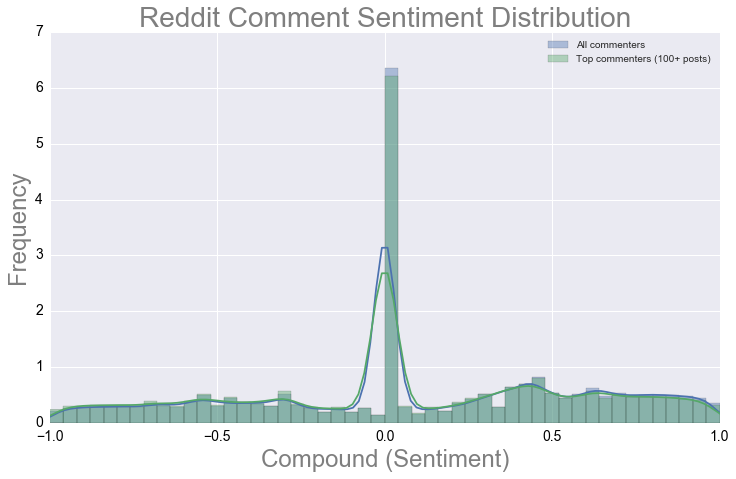

In [39]:
# Compare the sentiment distribution between top authors and all authors via histogram
x = data['compound']
y = top_authors['compound']

# Seaborn plot traits
sns.despine()
fig, ax = plt.subplots()
sns.distplot(x, bins=50,ax=ax,label="All commenters")
sns.distplot(y, bins=50,ax=ax,label="Top commenters (100+ posts)")
ax.set_xlim([-1,1 ])
ax.set_title('Reddit Comment Sentiment Distribution', fontsize=28,color="black",alpha=0.5)
ax.set_xlabel("Compound (Sentiment)",size = 24,color="black",alpha=0.5)
ax.set_ylabel("Frequency",size = 24,color="black",alpha=0.5)
ax.tick_params(labelsize=14,labelcolor="black")
ax.legend()

fig.set_size_inches(12,7)

In [63]:
# Statistics on sentiment, for all and top commenters:
print "Top author's (>100 comments) sentiment statistics:\n"
display(top_authors['compound'].describe())
print "\nAll author's sentiment statistics:\n"
display(data['compound'].describe())

Top author's (>100 comments) sentiment statistics:



count    1.432574e+06
mean     9.018814e-02
std      5.036999e-01
min     -1.000000e+00
25%     -2.411000e-01
50%      0.000000e+00
75%      4.927000e-01
max      1.000000e+00
Name: compound, dtype: float64


All author's sentiment statistics:



count    657971.000000
mean     0.065297     
std      0.506025     
min     -1.000000     
25%     -0.296000     
50%      0.000000     
75%      0.458800     
max      1.000000     
Name: compound, dtype: float64

##### Key Takeaways

Sentiment between all commenters and top commenters looks similar, with most sentiment clustered around neutral (median of 0.0)

### Features important to 'Score'

* Score (the combination of up and down votes) = an important metric to Reddit users
* Most users aspire for a 'high impact' score
* Most users likely want high scores, but some might aspire for low scores (e.g. 'trolls').

In this section, I will briefly consider some of the factors that appear to impact score.

#### 1. Body length and sentiment - impact on score

Correlation between score and body length:


,score,body_length
score,1.000000,0.014107
body_length,0.014107,1.000000


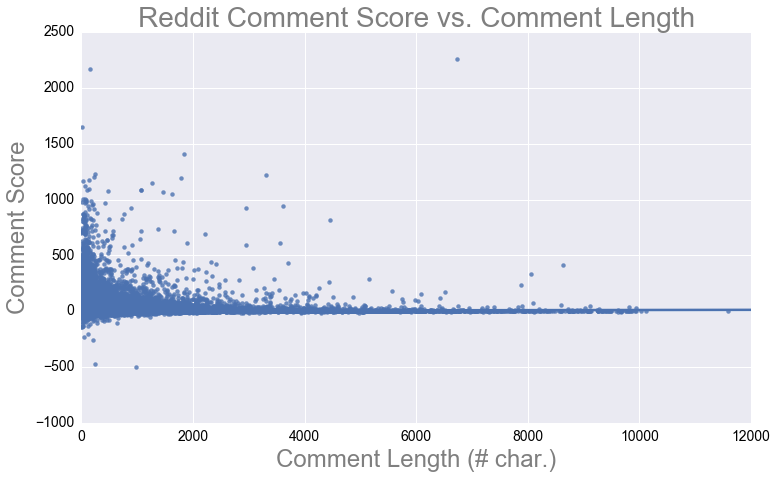

In [183]:
# Consider the impact of comment length on score
x = data.body_length
y = data.score

# Seaborn plot traits
sns.despine()
fig, ax = plt.subplots()
sns.regplot(x,y,data=data)
ax.set_xlim([0,12000])
ax.set_title('Reddit Comment Score vs. Comment Length', fontsize=28,color="black",alpha=0.5)
ax.set_xlabel("Comment Length (# char.)",size = 24,color="black",alpha=0.5)
ax.set_ylabel("Comment Score",size = 24,color="black",alpha=0.5)
ax.tick_params(labelsize=14,labelcolor="black")
ax.legend()

fig.set_size_inches(12,7)

print "Correlation between score and body length:"
data[['score','body_length']].corr()

Correlation between score and sentiment (compound):


,score,compound
score,1.000000,-0.009712
compound,-0.009712,1.000000


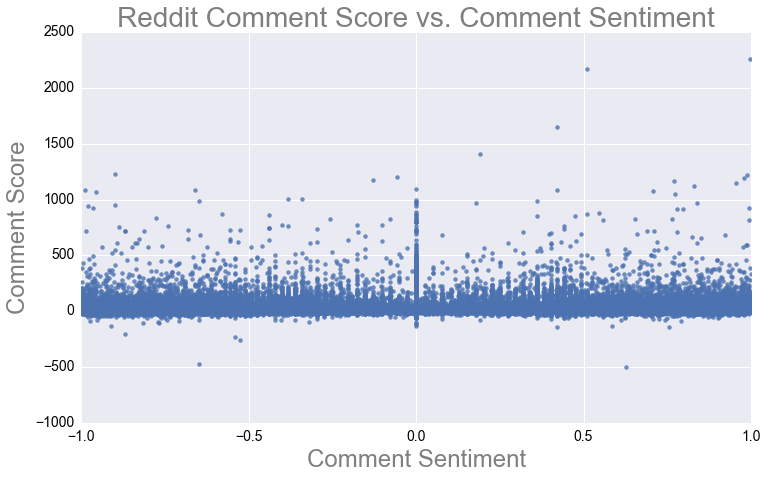

In [42]:
# Consider the impact of comment sentiment on score
x = data['compound']
y = data.score

# Seaborn plot traits
sns.despine()
fig, ax = plt.subplots()
sns.regplot(x,y,data=data)
ax.set_xlim([-1,1])
ax.set_title('Reddit Comment Score vs. Comment Sentiment', fontsize=28,color="black",alpha=0.5)
ax.set_xlabel("Comment Sentiment",size = 24,color="black",alpha=0.5)
ax.set_ylabel("Comment Score",size = 24,color="black",alpha=0.5)
ax.tick_params(labelsize=14,labelcolor="black")
ax.legend()

fig.set_size_inches(12,7)

print "Correlation between score and sentiment (compound):"
data[['score','compound']].corr()

##### Key Takeaways:

* Length appears to have an impact on score:
    * high scoring posts tend to be short
    * long posts elicit very pedestrian scores in general
    
* Sentiment appears to have little impact on score

#### 2. Subreddit impact on sentiment and score

In [156]:
# Group data by subreddit categories and limit to those with at least 24000 comments (~800 per day)
subreddit_data = data.groupby('subreddit').filter(lambda x: len(x) > 24000)

In [157]:
# Obtain average score and compound values across subreddits
big_subred = data[data.groupby('subreddit').id.transform(len) > 24000].groupby('subreddit')
x = big_subred.compound.mean()
y = big_subred.score.mean()
z = pd.concat([x, y], axis=1).reset_index()
print z

          subreddit  compound     score
0   AskReddit        0.108158  4.447173
1   DoesAnybodyElse  0.074090  2.734757
2   IAmA             0.132254  5.445467
3   WTF              0.008786  4.983137
4   atheism          0.081888  3.608484
5   funny            0.071768  7.010206
6   gaming           0.137235  3.929586
7   pics             0.060609  5.393165
8   politics        -0.006349  3.458994
9   programming      0.154437  3.920864
10  reddit.com       0.054655  3.705123
11  science          0.080697  4.231775
12  technology       0.092501  5.165412
13  worldnews       -0.044046  3.913601


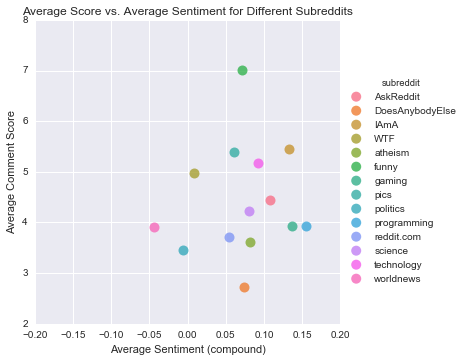

In [158]:
# Plot average score vs. average compound for different subreddit categories
g = sns.lmplot('compound', 'score', 
           data=z, 
           fit_reg=False, 
           hue='subreddit',
           scatter_kws={"marker": "D", 
                        "s": 100}
              )
plt.title('Average Score vs. Average Sentiment for Different Subreddits')
plt.xlabel('Average Sentiment (compound)')
plt.ylabel('Average Comment Score')
g.set(xlim=(-0.2,0.2))

fig.set_size_inches(12,7)

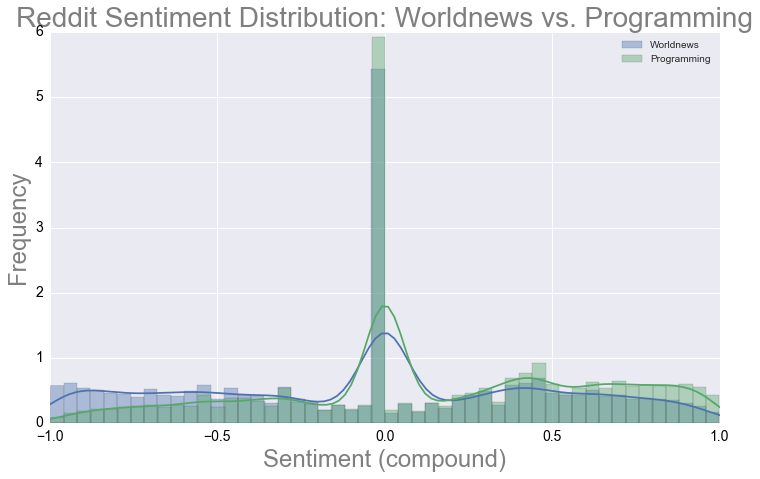

In [184]:
# Compare the sentiment distribution between the politics and programming subreddits
x = subreddit_data[subreddit_data['subreddit']=='worldnews']['compound']
y = subreddit_data[subreddit_data['subreddit']=='programming']['compound']

# Seaborn plot traits
sns.despine()
fig, ax = plt.subplots()
sns.distplot(x, bins=50,ax=ax,label="Worldnews")
sns.distplot(y, bins=50,ax=ax,label="Programming")
ax.set_xlim([-1,1])
ax.set_title('Reddit Sentiment Distribution: Worldnews vs. Programming', fontsize=28,color="black",alpha=0.5)
ax.set_xlabel("Sentiment (compound)",size = 24,color="black",alpha=0.5)
ax.set_ylabel("Frequency",size = 24,color="black",alpha=0.5)
ax.tick_params(labelsize=14,labelcolor="black")
ax.legend()

fig.set_size_inches(12,7)

In [76]:
# Statistics on sentiment, for worldnews vs. programming:
print "Sentiments statistics - worldnews subreddit:\n"
display(x.describe())
print "Sentiments statistics - programming subreddit:\n"
display(y.describe())

Sentiments statistics - worldnews subreddit:



count    32813.000000
mean    -0.044046    
std      0.531574    
min     -0.999100    
25%     -0.493900    
50%      0.000000    
75%      0.381800    
max      0.999400    
Name: compound, dtype: float64

Sentiments statistics - programming subreddit:



count    52353.000000
mean     0.154437    
std      0.487567    
min     -0.997700    
25%     -0.077200    
50%      0.025800    
75%      0.557400    
max      0.999600    
Name: compound, dtype: float64

##### Key Takeaways

The subreddit category has an impact on the average score: some subreddits are much more popular and hence the opportunity to get votes will be higher

The sentiment of subreddits is different. Some are likely to be more positive than others (e.g. worldnews has a lower average sentiment than program, with many more comments in the deeply negative compound range (-0.5 to -1)

### Map Individual Commenters to Score / Sentiment Space

#### 1. Classify comments as either 'long-winded' (>500 characters) or not

Length appears to be an important element of score, although not in a linear manner. Top scores tend to be short. Long comments tend to simply not get much attention, and hence not many votes, so scores tend to hover near the default ('1').

In [48]:
# Consider comments as either long-winded (>500 character body length average) or not
data['long_wind'] = 0
data.loc[data['body_length']>500,'long_wind'] = 1
data.long_wind.describe()

count    1.432574e+06
mean     9.512947e-02
std      2.933938e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: long_wind, dtype: float64

##### Key takeaway

About 10% of comments are long-winded (>500 characters)

#### 2. Per Author Features Assessment

Consider sentiment, body length and score on a per author basis

In [49]:
# Look at authors who average at least 1 post per day (i.e. 30 per month)
auth_data = data.groupby('author').filter(lambda x: len(x) > 30).groupby('author')

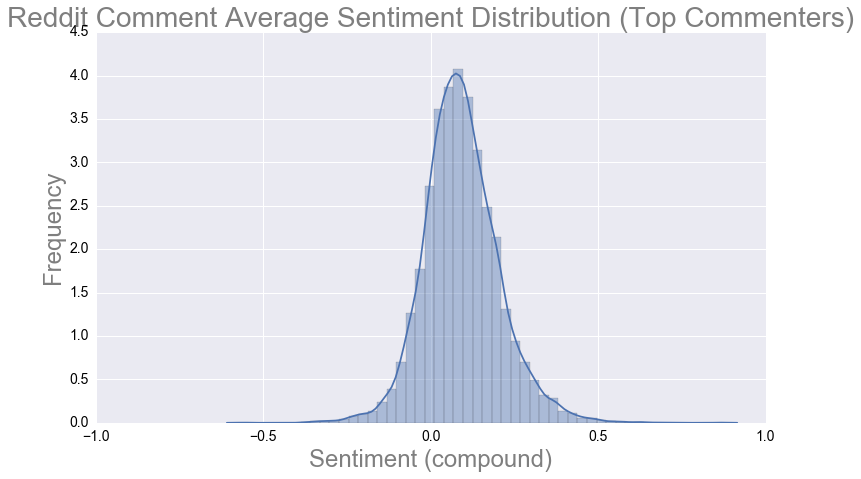

In [50]:
# Compare the sentiment distribution for top posters (>30 posts)
x = auth_data.compound.mean()

# Seaborn plot traits
sns.despine()
fig, ax = plt.subplots()
sns.distplot(x, bins=50,ax=ax)
ax.set_xlim([-1,1])
ax.set_title('Reddit Comment Average Sentiment Distribution (Top Commenters)', fontsize=28,color="black",alpha=0.5)
ax.set_xlabel("Sentiment (compound)",size = 24,color="black",alpha=0.5)
ax.set_ylabel("Frequency",size = 24,color="black",alpha=0.5)
ax.tick_params(labelsize=14,labelcolor="black")
ax.legend()

fig.set_size_inches(12,7)

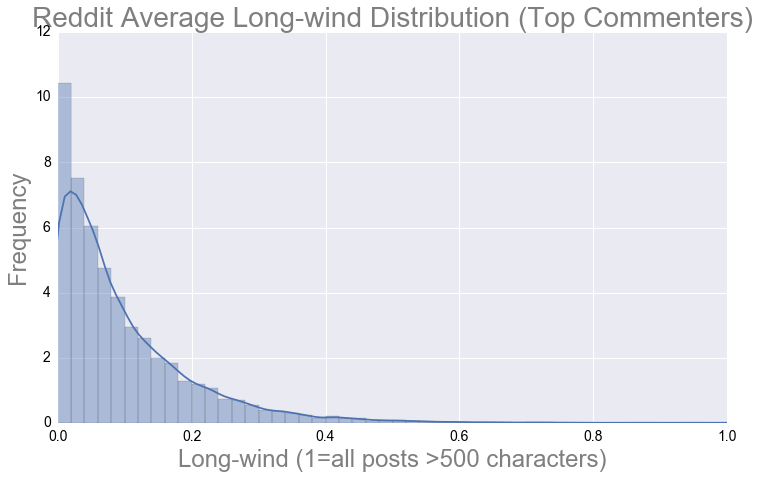

In [171]:
# Compare the long-windedness of top posters (>30 posts)
x = auth_data.long_wind.mean()

# Seaborn plot traits
sns.despine()
fig, ax = plt.subplots()
sns.distplot(x, bins=50,ax=ax)
ax.set_xlim([0,1])
ax.set_title('Reddit Average Long-wind Distribution (Top Commenters)', fontsize=28,color="black",alpha=0.5)
ax.set_xlabel("Long-wind (1=all posts >500 characters)",size = 24,color="black",alpha=0.5)
ax.set_ylabel("Frequency",size = 24,color="black",alpha=0.5)
ax.tick_params(labelsize=14,labelcolor="black")
ax.legend()

fig.set_size_inches(12,7)

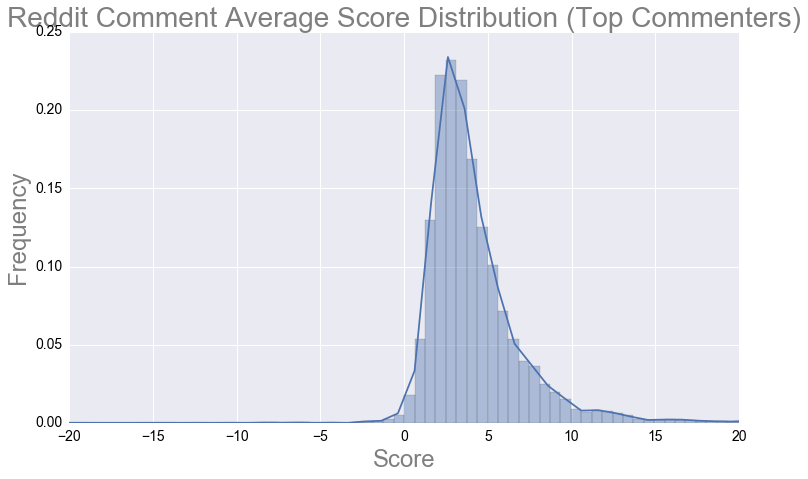

In [170]:
# Compare the score distribution for top posters (>30 posts)
x = auth_data.score.mean()

# Seaborn plot traits
sns.despine()
fig, ax = plt.subplots()
sns.distplot(x, bins=200,ax=ax)
ax.set_xlim([-20,20])
ax.set_title('Reddit Comment Average Score Distribution (Top Commenters)', fontsize=28,color="black",alpha=0.5)
ax.set_xlabel("Score",size = 24,color="black",alpha=0.5)
ax.set_ylabel("Frequency",size = 24,color="black",alpha=0.5)
ax.tick_params(labelsize=14,labelcolor="black")
ax.legend()

fig.set_size_inches(12,7)

In [176]:
# Create long-wind categories and a data set containing median values per author
n = auth_data.long_wind.median()
o = auth_data.compound.median()
p = auth_data.score.median()
q = pd.concat([n,o,p], axis=1).reset_index()
q['long-wind?'] = '<=25% of comments'
q.loc[q['long_wind']>=0.5,'long-wind?'] = '>=50% of comments'
q.loc[q['long_wind']<0.5,'long-wind?'] = '<50% of comments'

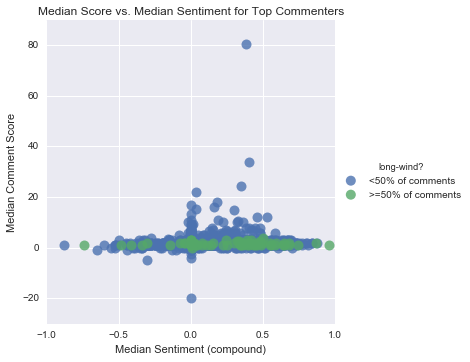

In [177]:
# Plot median compound and score for top commenters
g = sns.lmplot('compound', 'score', 
           data=q, 
           fit_reg=False, 
           hue='long-wind?',
           scatter_kws={"marker": "D", 
                        "s": 100}
              )
plt.title('Median Score vs. Median Sentiment for Top Commenters')
plt.xlabel('Median Sentiment (compound)')
plt.ylabel('Median Comment Score')
g.set(xlim=(-1,1))
g.set(ylim=(-30,90))

fig.set_size_inches(12,7)

In [174]:
# Create long-wind categories and a data set containing averages per author
w = auth_data.long_wind.mean()
x = auth_data.compound.mean()
y = auth_data.score.mean()
z = pd.concat([w,x,y], axis=1).reset_index()
z['long-wind?'] = '<=25% of comments'
z.loc[z['long_wind']>0.25,'long-wind?'] = '>25% of comments'
z.loc[z['long_wind']==0,'long-wind?'] = 'No long-winded comments'

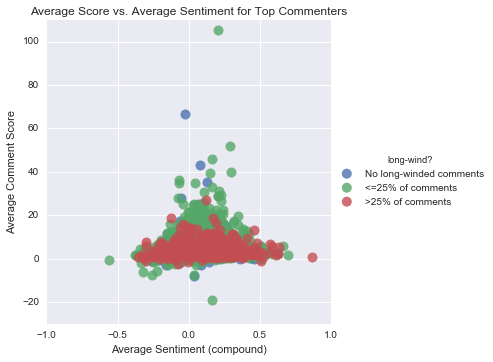

In [175]:
# Plot average compound and score for top commenters
g = sns.lmplot('compound', 'score', 
           data=z, 
           fit_reg=False, 
           hue='long-wind?',
           scatter_kws={"marker": "D", 
                        "s": 100}
              )
plt.title('Average Score vs. Average Sentiment for Top Commenters')
plt.xlabel('Average Sentiment (compound)')
plt.ylabel('Average Comment Score')
g.set(xlim=(-1,1))
g.set(ylim=(-30,110))

fig.set_size_inches(12,7)

##### Key takeaway

Being long-winded appears incompatible with high (>10) scores on reddit.com

#### 3. Analyze four types of authors:

* High score / average sentiment / not long-winded
* Neutral score / positive sentiment / very long-winded
* Low score / average sentiment / somewhat long-winded
* Neutral score / negative sentiment / somewhat long-winded

In [117]:
# Find specific authors with High score / average sentiment / not long-winded
print z[(z.score>60) & (z['long_wind']==0)]

         author  long_wind  compound      score               long-wind?
3612  aristeiaa  0.0       -0.025838  66.512821  No long-winded comments


In [88]:
display(data[['body','score','compound']][data['author']=='aristeiaa'])

,body,score,compound
11786,"really, i had no ideases",0,-0.3566
31515,Nice work! Would it be possible to figure out precisely which Rambo movie would involve him killing the population of the Earth?,26,-0.4389
31909,I think Mr Stallone needs to get cracking,6,0.0000
108954,It's a trap? Where the heck is that?,0,-0.3939
109068,You can have a package when you do your homework.,1,0.0000
109350,"I've grepped a copy of the screenplay, I can't find ""It's a trap"" anywhere, is it on a picture out of shot or something!?",0,0.3080
109506,"Well, all three of course, and the new Star Trek movie too.",3,0.2732
110186,"LOL, it's a trap!",4,0.3664
125296,"sorry, i'm not normally a bridge underdweller but it was too perfect :(",2,0.2617
166357,It's a spinal tap reference methinx,1,0.0000


##### Assessment:

The 'high score / not long-winded' author is a '1 hit wonder':
high average score is dependent on a single comment, posted in triplicate.

In [90]:
# Find specific authors with Neutral score / positive sentiment / very long-winded
print z[(z['long_wind']>0.25) & (z['compound']>0.75)]

          author  long_wind  compound  score        long-wind?
4178  cannuck210  0.7        0.865505  0.875  >25% of comments


In [91]:
display(data[['body','score','compound']][data['author']=='cannuck210'])

,body,score,compound
47168,"Our beautiful Decorative and Functional Pottery is all hand crafted in British Columbia and represents one of the largest web collections in North America. We have work from some of Canada’s finest award winning potters. Each piece is made using skills that have taken years to perfect. From Crystalline Glaze Vases to Pit Fired Bowls to complete ranges of dinner plates, casseroles, mugs, jugs - all of this work is unique, and being hand crafted, one of a kind. Because of the hand made nature of each piece your order may vary slightly from the one shown.",0,0.9747
59802,"Our superb Glass is all hand crafted in British Columbia. We have work from some of Canada’s finest award winning Glass artists. Each piece is made using skills that have taken many years to perfect. From Robert Held Vases and Perfum bottles to beautiful Bowls and Paperweights thought to Stained Glass. We even show Tealight holders and Hanging Glass displays and Friendship Balls. - all of this work is unique, and being hand crafted, one of a kind.",0,0.9853
76589,"Born in Santa Ana, California, Robert Held aspired to be an artist from an early age. His father, a sculptor, only lived six years of his son\'s life, but passed on the talent and appreciation of art that gave Robert the beginnings of a quest to create beauty in form and color. In High School his paintings won him the \""Ebell Award\"" for promising students. He studied painting at Whittier College until ceramics artist F. Carleton Ball crossed his path. To explore this new medium, Robert c ... [Read More]",0,0.9790
84492,Adorable pottery pig money box.The rubber bung on the base makes taking out your savings easy. A perfect present for young and old alike. Each is individually hand made on Vancouver Island so variations in detail will occur. Don't mess with this pig! 6 by 7 inches. Foodsafe.,0,0.9371
146720,"Master Wood Carver, Kees Luchs lives on the edge of the Lantzville Foothills on Vancouver Island, overlooking Georgia Strait. In his cedar sheltered workshop, he pursues his passion of making beautiful functional items from local and non-endangered exotic hardwoods.Each piece of hardwood is carefully selected for grain and colour configuration, so that no two items are ever the same. A European background and love for elegant simplicity is evident in the clean flowing, organic lines of his p ... [Read More]",1,0.9425
248743,"http://www.sidestreetstudio.com/catalog/silverworks-jewellery-m-80408.html\r\nFor as long as I can remember, I have experienced a strong connection with nature, animals and the outdoors. My fascination with rocks led me to countless days of walking the rivers and mountains in search of interesting stones, lightning wood and other unique pieces which we would one day, embody as elements in our jewelry designs. From ammolite hunting on the banks of The Old Man River to Shiva Shell collecting on the ocean shores of Malaysia or digging opals in Mexico all bring excitement and enlightenment to our designs. \r\nThe flowing rivers, the falling leaves in autumn, the radiant sunsets over the windswept ocean all provide inspiration in our One-of-a-kind pieces.\r\n\r\nANGELIQUE CEJKA\r\n\r\n&gt;From the time I was a little girl I often dreamed of creating beautiful jewelry. And it wasn\'t till many years later after meeting Alvin that my passion for jewelry was re-ignited. We discovered our shared enthusiasm for stones and designing. The first day we met (at a mutual friend\'s) Alvin had been out rock collecting and was eagerly polishing his stones. &gt;From that day onward a strong bond was formed between us and through our combined efforts and creative flair we began AA SilverWorks. We truly live and breathe designs on an almost daily basis. We\'re dedicated to creating jewelry that is of high-quality and yet affordable. We have transformed our passion for design into a flourishing venture and we believe our success can be attributed to our distinctive, wear

##### Assessment:

The extremely long-winded and positive author is a salesperson of some sort, attempting to sell various crafts

In [92]:
# Find specific authors with low score / average sentiment / somewhat long-winded
print z[(z['score']<-15)]

              author  long_wind  compound      score         long-wind?
4795  devilsadvocado  0.090909   0.16273  -19.284091  <=25% of comments


In [93]:
display(data[['body','score','compound']][data['author']=='devilsadvocado'])

,body,score,compound
45293,"I haven't done it in a while, but I used to be able to program my internal alarm clock to any time I wanted. I would just pick a random time or a time I needed to get up and focus on those digits as I fell asleep, also quietly praying to the clock gods to help wake me up. It was spooky how accurate it was.\n\nOnce I went to bed at 2am and had to wake up at 4:30 am in order to catch a shuttle to the airport. I had no alarm clock so I did my little trick and it worked.\n\nI also did it once to prove to a friend I could. We were sleeping in the same room. He told me to wake up at exactly 6:33 am and he would be awake watching me to make sure. Needless to say, he was impressed.",-26,0.8844
45336,...or feel a little less special.,-22,0.2798
77155,Dog shit everywhere. Only sweet bread for breakfast. Coffee that you finish in two sips. Ghost towns on Sunday and any evening after 10pm. Not a damn thing gets done in August. Hospitals and schools look like prisons.,-21,-0.4767
79191,*Bisous*,-20,0.0000
79309,There's nothing there.,-16,0.0000
141577,"It is possible to get them to attach a rakeback deal to your account, but it is a hassle. First, they have to see if you're even worth it for them--in other words, do they view you as a committed customer. The whole process can take upwards of a month.\n\nIf you're recreational, though, don't worry so much about rakeback. \n\nBy the way, you are playing WAY out of your league at NL50. Variance is a mean, mean monster: http://forumserver.twoplustwo.com/54/poker-beats-brags-variance/variance-simulator-535212/",-24,0.8522
180238,"You just magically transported me back to the Boys and Girls Club circa 1991: Wilmington, Delaware. Thank you.",-20,0.3612
182921,"Ramona Cordova is sheer magic.\n\nhttp://www.youtube.com/watch?v=hyV254h2RmU\n\nhttp://www.youtube.com/watch?v=_-4cBLHolTY\n\nHad the pleasure of seeing him perform in Lyon. He was opening for a larger band. No one in the audience knew him, except for me (so it seemed). By the time he finished his set, there wasn't a person in the crowd who wasn't smitten.",-20,0.4329
194102,"I guess you saw Devil's Playground. They don't really seem like the Reddit type, but there's got to be at least one or two of them.",-14,-0.1675
194154,The end of Ghost every time. Why I will always have a soft spot for Patrick Swayze.,-22,-0.3182


##### Assessment

The author with very low scores appears to be a troll of some sort. Many of their comments are not obviously offensive, yet they generate strong negative response from the reddit community.

In [95]:
# Find specific authors with Neutral score / negative sentiment / somewhat long-winded
print z[(z['compound']<-0.5)]

          author  long_wind  compound     score         long-wind?
912  Eurasian-HK  0.037838  -0.558979 -0.772973  <=25% of comments


In [96]:
display(data[['body','score','compound']][data['author']=='Eurasian-HK'])

,body,score,compound
15923,don't give this guy anymore attention. Obviously this Ted Kennedy thing is just a stunt to get some childish attention. If you really don't like what this preacher is saying close this tab and ignore the fact you heard his nonsense.,0,-0.8311
56618,"I pretty sure you can answer this question by asking yourself \n""How would you feel if you were on the receiving end of a break up telephone call, email or sms?""\n\nIf you think its okay to break up a relationship like this then you are a DOUCHEBAG",3,0.4883
63518,Wow these dog in the window pics are really so interesting i can hardly contain my excitement. Please show us more pics of uninteresting animals in window frames.,1,0.9165
64189,that's China for you,1,0.0000
64243,a person is smart... collectively people are stupid,8,-0.5267
103837,"He should have slapped the mother 4-5 times in the face for not controlling her child. The coddling of children in North America has gotten out of hand. Why is it child abuse, or even looked down upon, for a parent to discipline their children with back and front of their hand in public? Lets just get one thing straight Children aren't fully developed yet, which is why they don't understand things completely like most adult do. I think we can all agree on this point of Children not being full developed human beings. I can remember when i was a child my parents would go on and on about having consideration for other people, mainly about me getting up at 630am screaming at the top of my lungs about how awesome the weekend morning cartoons were on tv. I didn't understand what being considerate at 6am meant but i sure knew what a slap in mouth from my Mom or my Dad meant. I learned fast to ""be considerate"" and control the level of volume on the TV and my voice. I know people are going to cringe at this comparison but raising a toddler and a well trained puppy are almost the same. Its all about discipline, words don't mean anything to young children just like they don't really have much meaning for puppies. One thing that both puppies and children understand though is REWARDS and PUNISHMENT. Do something good get a reward do something bad get a punishment. I don't see where IGNORING the problem or behavior came from. Its bad parenting FULL STOP. NO IF ANDS OR BUTS. IF YOU IGNORE YOUR CHILDS BEHAVIOR THEN YOU ARE A BAD PARENT. In my eyes this behavior should be considered criminal and child abuse as they aren't giving the child a proper upbringing. If your puppy was chewing on your couch or pissing on your rug, would you just ignore the behavior too? No, you wouldn't, so i dont know why Children are ignored by there parents. Parenting is hard work, if you don't want to do the discipline part of parent hood then don't have FUCKING CHILDREN. STOP THE CODDLING",6,-0.9898
105173,you have too much free time,1,0.5106
111131,Remember when people use to take pride in their work?,17,0.3400
113630,WOW THIS IS SO INTERESTING,-3,0.7778
114019,all your name choices are lame and the kid will hate you for choosing a gay name for him,-1,-0.7579


##### Assessment

The author with very low sentiment not surprisingly posts a lot of negative comments.

### Key Findings 

* Small subset of dedicated commenters


* Yet, top commenters are not rewarded with higher scores


* Most comments on reddit are short


* Long-winded comments (>500 characters) = few high or low scores


* Subreddit matters for score and sentiment


* Individual commenters can be segmented in interesting ways

### Some Possible Next Steps

* Interactive graphs = really cool way to view reddit.com


* Machine learning applications:
    * Score prediction, using above features and NLP (in progress)
    * Unsupervised learning to classify authors into categories (possible moderator application) 
    
    
* Sentiment analysis improvement (compared to VADER) using Reddit corpus